# Building LSTM Networks using Keras
---

# Introduction

In this notebook, we will discover the world of LSTM through Keras. 


## Why Keras?

Because it was one of the first open-soruce python library to provide LSTM networks in its collection along **Lasagne** and **Block**. **Caffee** added it later on (2015).

It is built on top of **TensorFlow**, **CNTK**, or **Theano**, and hence is pretty effective.


## Other libraries

We will also use tools from the following libraries:
- matplotlib
- numpy
- sckitlearn
- tensorflow


## Sources

Here is a bunch of good lectures / videos about LSTM / RNN:
- (rrn overview) https://ayearofai.com/rohan-lenny-3-recurrent-neural-networks-10300100899b
- (music generation) https://www.youtube.com/watch?v=aSr8_QQYpYM + https://drive.google.com/file/d/0B7oYxDkqYqqPYlR2LU01LVktbUU/view
- (examples) http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/


## Data

- nottingham.txt: http://abc.sourceforge.net/NMD/nmd/jigs.txt


---

# Data

We want to be able to forecast the number a passengers.

In [1]:
import pandas
import matplotlib.pyplot as plt

In [2]:
path = "data/international-airline-passengers.csv"

# Display tail of file
with open(path) as file:
    print("".join(file.readlines()[:10]))

"Month","passengers (thousands)"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
"1949-06",135
"1949-07",148
"1949-08",148
"1949-09",136



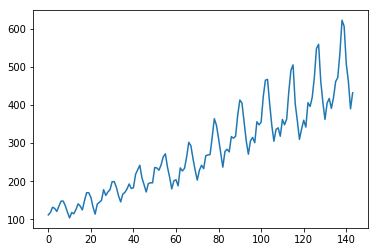

In [3]:
dataframe = pandas.read_csv(path, usecols=[1], engine='python', skipfooter=3)
plt.plot(dataframe)
plt.show()

---

# LSTM - Tools

## Preparing preprocessing

In [4]:
import numpy as np


def create_XY(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def create_sets(dataframe, scaler, ratio=0.67, look_back=1, input_type='simultaneous'):

    # Create dataset
    dataset = dataframe.values.astype('float32')

    # Normalize
    ds = scaler.fit_transform(dataset)

    # Split dataset in train, test
    train_size = int(len(ds) * ratio)
    train, test = ds[0:train_size, :], ds[train_size:len(dataset), :]

    # Reshape data
    trainX, trainY = create_XY(train, look_back)
    testX, testY = create_XY(test, look_back)

    # Reshape input to be [samples, time steps, features]
    if input_type is 'simultaneous':
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    elif input_type is 'sequential':
        trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
        testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    else:
        raise ValueError(
            "Input type can be 'sequential' or 'simultaneous', got %s"
            % input_type
        )
        
    return ds, trainX, trainY, testX, testY


## Model

In [34]:
import math

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


def create_LSTM(input_shape, look_back, stateful, batch_size, layers):
    model = Sequential()
    for layer_i in range(layers):
        if layer_i < layers - 1:
            return_sequences = True
        else:
            return_sequences = False
        model.add(
            LSTM(
                4,
                batch_input_shape=(batch_size, input_shape[0], input_shape[1]),
                stateful=stateful,
                return_sequences=return_sequences,
            )
        )
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

## Testing

In [35]:
def test(model, scaler, trainX, trainY, testX, testY, batch_size):
    # make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    testPredict = model.predict(testX, batch_size=batch_size)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainPredict, testPredict


def display(ds, trainPredict, testPredict, scaler, look_back):
    # Show results

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(ds)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(ds)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict

    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(ds))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

## Run all

In [36]:
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping

def run(dataframe, look_back, input_type='simultaneous', stateful=False, layers=1, verbose=0):
    
    np.random.seed(7)
    batch_size = 1
    
    # Setting things up
    scaler = MinMaxScaler(feature_range=(0, 1))
    ds, trainX, trainY, testX, testY = create_sets(
        dataframe, scaler,
        look_back=look_back,
        input_type=input_type,
    )
    
    print("Input shape:", trainX.shape[1:])

    if input_type is 'simultaneous':
        input_shape = (1, look_back)
    elif input_type is 'sequential':
        input_shape = (look_back, 1)
    else:
        raise ValueError(
            "Input type can be 'sequential' or 'simultaneous', got %s"
            % input_type
        )
    model = create_LSTM(input_shape, look_back=look_back, stateful=stateful, batch_size=batch_size, layers=layers)
    
    # Training
    if stateful:
        for i in range(100):
            model.fit(
                trainX,
                trainY,
                epochs=1,
                batch_size=1,
                verbose=verbose,
                shuffle=False,
            )
            model.reset_states()
    else:
        # earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=0, mode='auto')
        model.fit(
            trainX,
            trainY,
            epochs=100,
            batch_size=batch_size,
            # callbacks=[earlystop],
            verbose=verbose,
        )
    
    trainPredict, testPredict = test(model, scaler, trainX, trainY, testX, testY, batch_size=batch_size)
    display(ds, trainPredict, testPredict, scaler, look_back)

# Tests

## Regression

> **one to one** RNN with **scalar input**

Input shape: (1, 1)
Train Score: 22.93 RMSE
Test Score: 47.53 RMSE


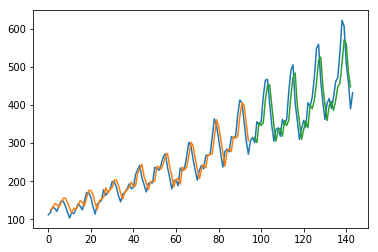

In [37]:
run(dataframe, look_back=1)

## Regression with Window Method

> **one to one** RNN with **vector input**

Input shape: (1, 3)
Train Score: 24.19 RMSE
Test Score: 58.04 RMSE


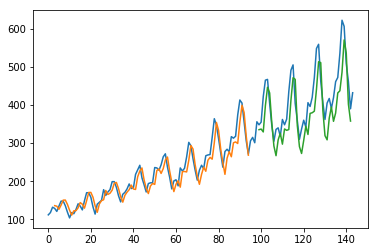

In [31]:
run(dataframe, look_back=3)

## Regression with time step
> **many to one** RNN with **scalar input**

Input shape: (3, 1)
Train Score: 23.69 RMSE
Test Score: 58.85 RMSE


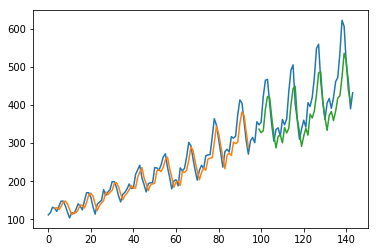

In [32]:
run(dataframe, look_back=3, input_type='sequential')

## Memory Between Batches

Input shape: (3, 1)
Train Score: 20.74 RMSE
Test Score: 50.74 RMSE


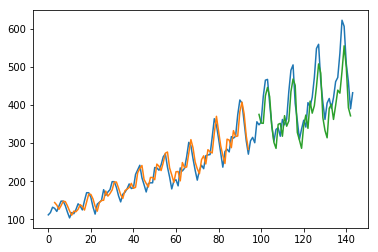

In [33]:
run(dataframe, look_back=3, input_type='sequential', stateful=True)

## Stacked LSTM

Input shape: (3, 1)
Train Score: 20.48 RMSE
Test Score: 54.78 RMSE


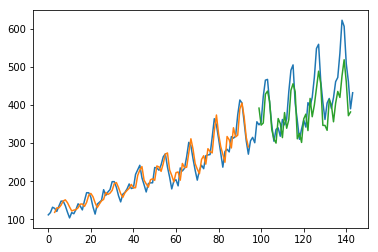

In [38]:
run(dataframe, look_back=3, input_type='sequential', stateful=True, layers=2)